### Synthetic dataset generation

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns

torch.manual_seed(1337)  

# Parameters
num_samples = 1000  #Corresponds to m in the paper
dim_x = 10  
dim_y = 10  

# Dataset creation

# Matrix creation
def random_positive_diagonal_matrix(n, m):
    # Generate evenly spaced positive distinct values
    values = torch.linspace(1, 10, steps=n)
    # Shuffle the values to make them random
    values = values[torch.randperm(n)]
    # Create a diagonal matrix of size (n x n)
    D = torch.diag(values)
    # If n != m, pad or truncate the diagonal matrix to size (n x m)
    if n < m:
        D = torch.cat([D, torch.zeros(n, m - n)], dim=1)
    elif n > m:
        D = D[:m, :m]
    return D
    
def random_orthogonal_matrix(n,m):
    U, _ = torch.linalg.qr(torch.randn(n, m), mode='reduced')
    return U
    
def diagonal_matrix_with_d_distinct_values(m, n, d):
    min_dim = min(m, n)
    if d > min_dim or d < 1:
        raise ValueError("d must satisfy 1 <= d <= min(m, n)")

    # Generate d distinct positive values
    distinct_values = torch.linspace(1, 10, steps=d)

    # Repeat the distinct values to fill the diagonal
    diagonal_values = torch.cat([distinct_values, distinct_values[:min_dim - d]])

    # Shuffle the diagonal values to randomize their order
    diagonal_values = diagonal_values[torch.randperm(min_dim)]

    # Create a rectangular diagonal matrix
    D = torch.zeros(m, n)
    for i in range(min_dim):
        D[i, i] = diagonal_values[i]
    return D

def diagonal_matrix_with_d_zeros(m, n, d):

    min_dim = min(m, n)
    if d > min_dim or d < 0:
        raise ValueError("d must satisfy 0 <= d <= min(m, n)")

    # Generate non-zero values for the diagonal
    non_zero_values = torch.ones(min_dim - d)  # You can replace this with other positive values

    # Combine zeros and non-zero values
    diagonal_values = torch.cat([torch.zeros(d), non_zero_values])

    # Shuffle the diagonal values to randomize the positions of zeros
    diagonal_values = diagonal_values[torch.randperm(min_dim)]

    # Create a rectangular diagonal matrix
    D = torch.zeros(m, n)
    for i in range(min_dim):
        D[i, i] = diagonal_values[i]

    return D
    
#Satisfying all conditions
U=random_orthogonal_matrix(dim_y,dim_y)
V=random_orthogonal_matrix(num_samples,num_samples)
D=random_positive_diagonal_matrix(dim_y, num_samples)

U_p=random_orthogonal_matrix(dim_y,dim_y)
D_p=random_positive_diagonal_matrix(dim_y, num_samples)

X=U @ D @ V.T
Y=U_p @ D_p @ V.T

#Not satisfying condition (1)
'''
D2_p=diagonal_matrix_with_d_distinct_values(dim_y,num_samples , dim_y/2)
Y2=U_p @ D2_p @ V.T
X2=U @ D @ V.T #still ok
#Not satisfying condition (2)
D3=diagonal_matrix_with_d_zeros(dim_x,num_samples , dim_x/2)
Y3=U_p @ D_p @ V.T #still ok
#Not satisfying condition (3)
'''
'''
X = torch.randn(num_samples, dim_x)
true_weights = torch.randn(dim_x, dim_y)
Y = X @ true_weights + 0.1 * torch.randn(num_samples, dim_y) #Y = XW + noise
'''

# Create a TensorDataset and DataLoader
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X, Y)
batch_size = len(dataset)  # Full-batch mode

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [2]:
import numpy as np

def check_conditions(X, Y):
    """
    Checks the following conditions for matrices X (d_x x m) and Y (d_y x m):
      1. d_x >= d_y
      2. Sigma = YX^T (XX^T)^{-1} XY^T has d_y distinct eigenvalues.
      3. XX^T is full rank (i.e. rank = d_x).
      4. XY^T is full rank (i.e. rank = d_y).
    
    Returns a dictionary with the verification result ("yes" or "no")
    for each condition.
    """
    results = {}
    
    # Extract dimensions
    d_x, m1 = X.shape
    d_y, m2 = Y.shape

    # Condition 1: d_x >= d_y
    results["Condition 1 verified"] = "yes" if d_x >= d_y else "no"

    # Condition 3: XX^T has full rank (rank should equal d_x)
    XXT = X @ X.T
    rank_XXT = np.linalg.matrix_rank(XXT)
    condition3_verified = (rank_XXT == d_x)
    results["Condition 3 verified"] = "yes" if condition3_verified else "no"

    # Condition 4: XY^T has full rank (rank should equal d_y)
    XYT = X @ Y.T
    condition4_verified = (np.linalg.matrix_rank(XYT) == d_y)
    results["Condition 4 verified"] = "yes" if condition4_verified else "no"

    # Condition 2: Sigma = YX^T (XX^T)^{-1} XY^T has d_y distinct eigenvalues.
    # This condition is only sensible if XX^T is invertible (i.e. Condition 3 holds)
    if condition3_verified:
        try:
            inv_XXT = np.linalg.inv(XXT)
        except np.linalg.LinAlgError:
            inv_XXT = None
        
        if inv_XXT is not None:
            Sigma = Y @ X.T @ inv_XXT @ X @ Y.T
            eigvals = np.linalg.eigvals(Sigma)
            # Round eigenvalues to 6 decimal places to account for numerical precision.
            unique_eigs = np.unique(np.round(eigvals, decimals=6))
            condition2_verified = (len(unique_eigs) == d_y)
            results["Condition 2 verified"] = "yes" if condition2_verified else "no"
        else:
            results["Condition 2 verified"] = "no"
    else:
        results["Condition 2 verified"] = "no"
    
    return results

In [3]:

X_sus = np.zeros((5,5))
Y_sus = np.zeros((5,5))
# Check each condition.
condition_results = check_conditions(X_sus, Y_sus)
    
    # Print the results.
for condition, verified in condition_results.items():
    print(f"{condition}: {verified}")

Condition 1 verified: yes
Condition 3 verified: no
Condition 4 verified: no
Condition 2 verified: no


### Model instantiation, optimizer and loss function

In [4]:
import torch.nn as nn
import sys
import os

# Import 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from Utils.classes import LinearNN

# Define hidden layer dimensions
hidden_dims = [64, 32]

# Instantiate the model
# Directly pass hidden dimensions as positional arguments
model = LinearNN(dim_x=10, dim_y=1, hidden_dims=hidden_dims)


# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
learning_rate = 0.01
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)

### Linear Experment 1: no poor local minima

In [24]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

class LinearNN(nn.Module):
    def __init__(self, dim_x, dim_y, hidden_dims=[64, 32]):
        super(LinearNN, self).__init__()
        layers = []
        input_dim = dim_x
        
        for hdim in hidden_dims:
            layers.append(nn.Linear(input_dim, hdim))
            layers.append(nn.ReLU())
            input_dim = hdim
        
        # Final layer
        layers.append(nn.Linear(input_dim, dim_y))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

def run_multiple_inits_plot(
    X,
    Y,
    hidden_dims: list = [64, 32],
    learning_rate: float = 0.01,
    num_runs: int = 5,
    num_iterations: int = 100
):
    """
    Trains a model multiple times (each with a new random initialization)
    and plots the final loss of each run.

    Automatically handles data where columns = observations:
      - X of shape (dim_x, m)
      - Y of shape (dim_y, m)
    by transposing them to PyTorch's conventional format:
      - (m, dim_x) and (m, dim_y).
    
    If data is already in row-major format (m, dim_x)/(m, dim_y),
    it does nothing.

    Args:
        X (array-like): Input features. Can be:
            (dim_x, m) or (m, dim_x) as numpy or torch.Tensor.
        Y (array-like): Targets. Can be:
            (dim_y, m) or (m, dim_y) as numpy or torch.Tensor.
        hidden_dims (list): List of hidden layer sizes for the MLP.
        learning_rate (float): Learning rate for the optimizer.
        num_runs (int): How many times to re-initialize and train the model.
        num_iterations (int): Number of full-batch training epochs per run.
    """

    # 1) Convert NumPy arrays to torch.Tensors if needed
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X).float()
    if isinstance(Y, np.ndarray):
        Y = torch.from_numpy(Y).float()

    # 2) Check dimensionality
    # We assume X, Y each have 2 dims: either (dim_x, m) or (m, dim_x).
    if X.dim() != 2 or Y.dim() != 2:
        raise ValueError("X and Y must be 2D tensors/arrays.")

    # 3) If the first dimension doesn't match, we assume columns are samples.
    #    => we transpose both to have (m, dim_x)/(m, dim_y).
    if X.shape[0] != Y.shape[0]:
        # In your scenario: X is (dim_x, m), Y is (dim_y, m)
        # Check that they have same # of columns => m
        if X.shape[1] != Y.shape[1]:
            raise ValueError(
                f"X and Y have different number of columns: {X.shape[1]} vs {Y.shape[1]}"
            )
        # Transpose them
        X = X.T  # (m, dim_x)
        Y = Y.T  # (m, dim_y)

    # Now X.shape[0] == Y.shape[0], so row i corresponds to sample i
    # X => (m, dim_x), Y => (m, dim_y)

    # 4) Infer dim_x, dim_y from the (m, dim_x) and (m, dim_y) shapes
    dim_x = X.size(1)
    dim_y = Y.size(1)

    # 5) Create a DataLoader in full-batch mode
    dataset = TensorDataset(X, Y)
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

    final_losses = []
    final_params_list = []
    
    # 6) Outer progress bar: how many runs are completed
    for run_id in tqdm(range(num_runs), desc="Overall runs"):
        # Set the seed so each run has a reproducible but unique init
        torch.manual_seed(run_id)
        np.random.seed(run_id)
        
        # Create a fresh model and optimizer each run
        model = LinearNN(dim_x, dim_y, hidden_dims)
        optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        
        # Inner progress bar: training epochs
        for epoch in tqdm(range(num_iterations), desc=f"Run {run_id}", leave=False):
            model.train()
            for batch_X, batch_Y in dataloader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_Y)
                loss.backward()
                optimizer.step()
        
        # Record the final loss and parameters
        final_loss = loss.item()  # last computed loss
        final_losses.append(final_loss)

        # Flatten and store final parameters
        final_params = torch.cat([p.flatten() for p in model.parameters()]).detach().cpu()
        final_params_list.append(final_params)
    
    # 7) Plot final losses across runs (using seaborn styling)
    sns.set_style("whitegrid")
    sns.set_palette("husl")  # Use a nice color palette
    
    plt.figure(figsize=(8, 5))
    bars = plt.bar(range(num_runs), final_losses, edgecolor="black", alpha=0.8)
    
    # Add annotations (values on top of bars)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.4f}",
                 ha="center", va="bottom", fontsize=6)
    
    # Add a horizontal line for the mean loss
    mean_loss = np.mean(final_losses)
    plt.axhline(mean_loss, color="red", linestyle="--", linewidth=1.5, label=f"Mean Loss: {mean_loss:.4f}")
    
    # Customize labels and title
    plt.xlabel("Run Index (Seed)", fontsize=12)
    plt.ylabel("Final Training Loss", fontsize=12)
    plt.title("Final Training Loss for Multiple Runs (Different Initializations)", fontsize=14, pad=20)
    
    # Add legend
    plt.legend(loc="upper right", fontsize=10)
    plt.tight_layout()
    
    plt.show()

    # Return the final losses and parameters for further analysis
    return final_losses, final_params_list


Overall runs: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


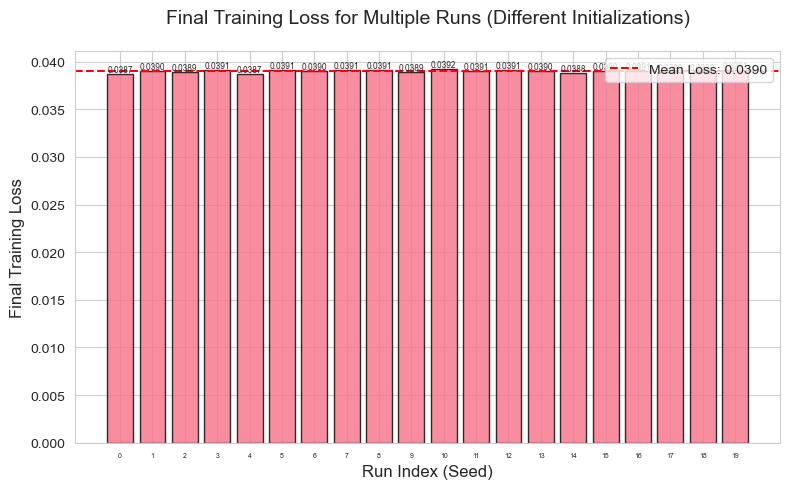

In [6]:
final_losses, final_params = run_multiple_inits_plot(
    X, Y,
    hidden_dims=[64, 32],
    learning_rate=0.01,
    num_runs=20,
    num_iterations=500
)

In [7]:
def biggest_difference(list):
    
    # Calculate the maximum and minimum values in the list
    max_value = max(list)
    min_value = min(list)
    
    # Compute the biggest difference
    biggest_diff = max_value - min_value
    
    return biggest_diff

In [8]:
def param_distance(p1, p2):
    # p1 and p2 are PyTorch tensors
    return torch.norm(p1 - p2).item()

In [9]:
import numpy as np
import matplotlib.pyplot as plt

num_runs = len(final_params)
dist_matrix = np.zeros((num_runs, num_runs))

for i in range(num_runs):
    for j in range(num_runs):
        dist_matrix[i, j] = param_distance(final_params[i], final_params[j])



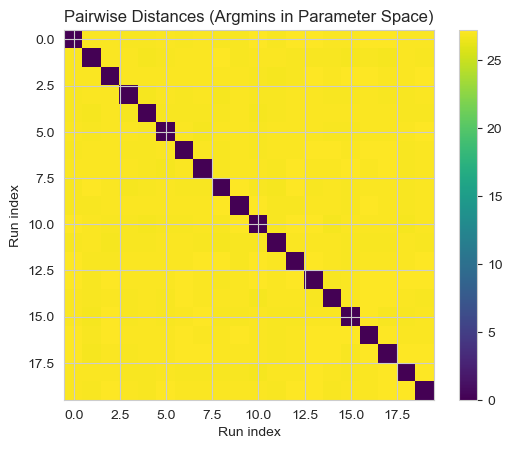

In [10]:
plt.imshow(dist_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xlabel("Run index")
plt.ylabel("Run index")
plt.title("Pairwise Distances (Argmins in Parameter Space)")
plt.show()


They are indeed different argmin!

### Experiment 2: violating the conditions of the theorem


Let's first explore the case when $XX^T$ is not invertible:

In [28]:
import numpy as np

def generate_X_with_rank(dim_x, m, desired_rank):
    """
    Generates a matrix X of size (dim_x, m) such that XX^T has the given rank.

    Parameters:
        dim_x (int): Number of rows in X.
        m (int): Number of columns in X.
        desired_rank (int): Target rank of XX^T (must be ≤ min(dim_x, m)).

    Returns:
        X (numpy.ndarray): A matrix such that XX^T has the specified rank.
    """
    if desired_rank > min(dim_x, m):
        raise ValueError(f"Desired rank must be at most min({dim_x}, {m}).")
    
    # Step 1: Create a random matrix of full rank (desired_rank x m)
    full_rank_X = np.random.randn(desired_rank, m)
    
    # Step 2: Expand it to a (dim_x, m) matrix by padding with dependent rows
    X = np.vstack([full_rank_X, np.zeros((dim_x - desired_rank, m))])
    
    # Step 3: Randomly shuffle rows to avoid obvious zero patterns
    np.random.shuffle(X)
    
    return X

# Example usage
dim_x, m, desired_rank = 10, 1000, 5  # Generate X so that XX^T has rank 5
X = generate_X_with_rank(dim_x, m, desired_rank)

# Compute XX^T and its rank
XXT = X @ X.T
rank = np.linalg.matrix_rank(XXT)
print(f"Generated X of shape {X.shape}, rank of XX^T: {rank} (Expected: {desired_rank})")


Generated X of shape (10, 1000), rank of XX^T: 5 (Expected: 5)


In [41]:
dim_x, m = 20, 100  
X = generate_X_with_rank(dim_x, m, 14)

# Check rank of XX^T
XXT = X @ X.T
rank = np.linalg.matrix_rank(XXT)
print(f"Rank of XX^T: {rank} (Expected: < {dim_x} for singularity)")
Y = np.random.uniform(0, 1, (10, 100))

Rank of XX^T: 14 (Expected: < 20 for singularity)


Overall runs: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


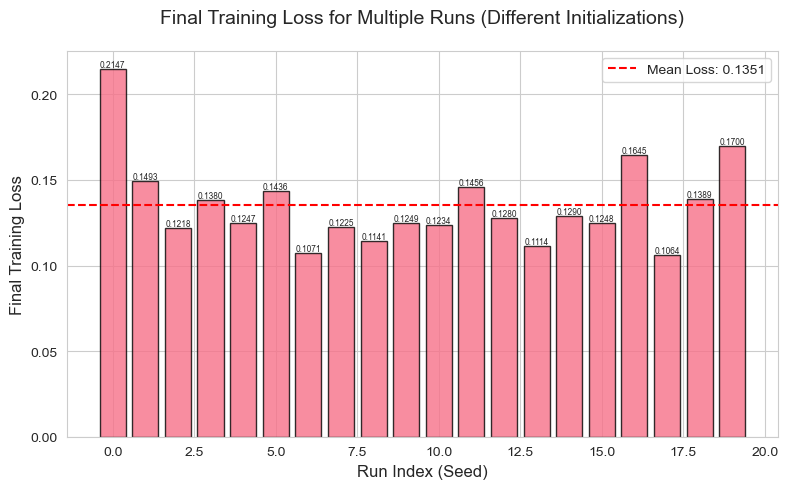

In [39]:
final_losses, final_params = run_multiple_inits_plot(
    X, Y,
    hidden_dims=[64, 32],
    learning_rate=0.01,
    num_runs=20,
    num_iterations=500
)

In [16]:
num_runs = len(final_params)
dist_matrix = np.zeros((num_runs, num_runs))

for i in range(num_runs):
    for j in range(num_runs):
        dist_matrix[i, j] = param_distance(final_params[i], final_params[j])


Distinct argmin verification

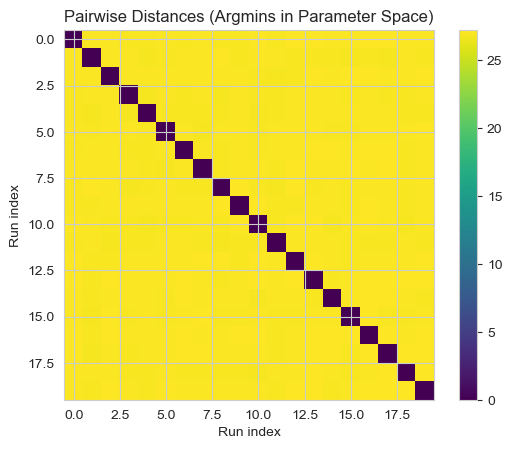

In [17]:
plt.imshow(dist_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xlabel("Run index")
plt.ylabel("Run index")
plt.title("Pairwise Distances (Argmins in Parameter Space)")
plt.show()